In [1]:
import torch 
import os 
import cv2 
from importlib import import_module
import matplotlib.pyplot as plt 
import json 
import numpy as np 

/home/kjs2109/.conda/envs/deepai-kjs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(model, model_class, target_classes, use_aux, weight_path): 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    model_module = getattr(import_module(f"models.{model}"), model_class)
    model = model_module(target_classes, use_aux) 

    model.load_state_dict(torch.load(weight_path)) 
    model = model.to(device)
    return model

In [3]:
model1 = load_model('unet', "EfficientUNet", ['Pnuemothorax'], use_aux=False, weight_path='/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/exp8_1f_effiU-b5_base-scratch/dice-7271-114999.pth') 
model2 = load_model('unet', "EfficientUNet", ['Pnuemothorax'], use_aux=False, weight_path='/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/exp10_1f_effiU-b5_base-copypaste/dice-7987-43999.pth') 


In [4]:
model1.eval(), model2.eval() 
model1.cpu(), model2.cpu() 

(EfficientUNet(
   (model): Unet(
     (encoder): EfficientNetEncoder(
       (_conv_stem): Conv2dStaticSamePadding(
         3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
         (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
       )
       (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
       (_blocks): ModuleList(
         (0): MBConvBlock(
           (_depthwise_conv): Conv2dStaticSamePadding(
             48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
             (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
           )
           (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
           (_se_reduce): Conv2dStaticSamePadding(
             48, 12, kernel_size=(1, 1), stride=(1, 1)
             (static_padding): Identity()
           )
           (_se_expand): Conv2dStaticSamePadding(
             12, 48, kernel

In [5]:
import albumentations as A 

transform = A.Resize(512, 512) 

test_image = cv2.imread('/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_010675.jpg', cv2.IMREAD_COLOR)
transformed_test_image = transform(image=test_image)['image']
transformed_test_image = torch.from_numpy(transformed_test_image.transpose(2, 0, 1) / 255.).float()  

print(transformed_test_image.shape, transformed_test_image.max(), transformed_test_image.min(), transformed_test_image.dtype) 


torch.Size([3, 512, 512]) tensor(1.) tensor(0.) torch.float32


In [6]:
with torch.no_grad():
    output1 = model1(transformed_test_image.unsqueeze(0)) 
    output2 = model2(transformed_test_image.unsqueeze(0))  

In [7]:
logit1 = output1['mask_output'] 
logit2 = output2['mask_output'] 

cls1 = output1['cls_output'] 
cls2 = output2['cls_output'] 

print(logit1.shape, logit2.shape) 
print(logit1.max(), logit1.min(), logit1.dtype) 
print(logit2.max(), logit2.min(), logit2.dtype) 
print(cls1, cls2) 

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
tensor(4.8684) tensor(-21.5026) torch.float32
tensor(4.4941) tensor(-29.7024) torch.float32
None None


In [36]:
prob1 = torch.sigmoid(logit1) 
prob2 = torch.sigmoid(logit2) 

print(prob1.max(), prob1.min(), prob1.dtype)
print(prob2.max(), prob2.min(), prob2.dtype)

tensor(0.9924) tensor(4.5869e-10) torch.float32
tensor(0.9889) tensor(1.2602e-13) torch.float32


In [40]:
mask1 = (prob1 > 0.5) 
mask2 = (prob2 > 0.5) 

print(mask1.shape, mask2.shape) 
print(mask1.max(), mask1.min(), mask1.dtype) 
print(mask2.max(), mask2.min(), mask2.dtype) 

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
tensor(True) tensor(False) torch.bool
tensor(True) tensor(False) torch.bool


In [42]:
ensemble_prob = (prob1 + prob2) / 2.
ensemble_mask = (ensemble_prob > 0.5) 

print(ensemble_prob.shape, ensemble_mask.shape)
print(ensemble_prob.max(), ensemble_prob.min(), ensemble_prob.dtype)
print(ensemble_mask.max(), ensemble_mask.min(), ensemble_mask.dtype) 

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
tensor(0.8981) tensor(9.9059e-10) torch.float32
tensor(True) tensor(False) torch.bool


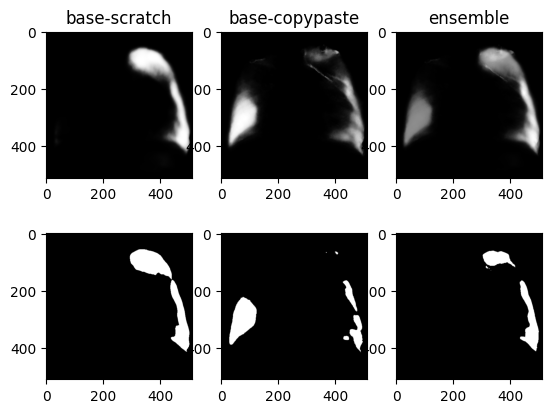

In [43]:
plt.subplot(2, 3, 1) 
plt.imshow(prob1.squeeze().numpy(), cmap='gray') 
plt.title('base-scratch')

plt.subplot(2, 3, 2) 
plt.imshow(prob2.squeeze().numpy(), cmap='gray') 
plt.title('base-copypaste') 

plt.subplot(2, 3, 3) 
plt.imshow(ensemble_prob.squeeze().numpy(), cmap='gray') 
plt.title('ensemble')

plt.subplot(2, 3, 4)
plt.imshow(mask1.squeeze().numpy(), cmap='gray')

plt.subplot(2, 3, 5)
plt.imshow(mask2.squeeze().numpy(), cmap='gray') 

plt.subplot(2, 3, 6)
plt.imshow(ensemble_mask.squeeze().numpy(), cmap='gray')

plt.show() 

In [46]:
label_path = '/ai-data/chest/kjs2109/private_data/chestALL/anns/1findings_v0/BORA_CXR_010675.json' 

label = json.load(open(label_path, 'r'))  

anns = label['annotations'] 
len(anns) 

4

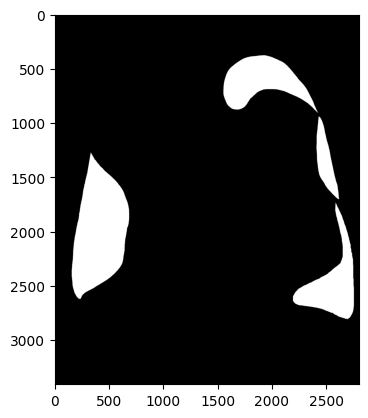

In [67]:
h, w = test_image.shape[:2]
gt_mask = np.zeros((h, w), np.int32) 
for ann in anns: 
    polygon = ann['segmentation'][0] 
    polygon_x = [x for i, x in enumerate(polygon) if i % 2 == 0] 
    polygon_y = [y for i, y in enumerate(polygon) if i % 2 == 1] 
    polygon_xy = np.array([[x, y] for x, y in zip(polygon_x, polygon_y)], np.int32) 
    cv2.fillPoly(gt_mask, [polygon_xy], 1)

plt.imshow(gt_mask, cmap='gray')
plt.show() 

In [86]:
m = torch.tensor([
    [[1, 2, 3], 
     [4, 5, 6], 
     [7, 8, 9]], 
    [[1, 2, 3], 
     [4, 5, 6], 
     [7, 8, 9]]
    ]) 

m = m.unsqueeze(0) 

print(m.shape) 

b, c, h, w = m.shape 

torch.Size([1, 2, 3, 3])


In [84]:
max_value, max_index = m.max(dim=1)  
max_value.shape 

torch.Size([1, 3, 3])

In [85]:
max_value

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [88]:
max_v, max_i = m.view(b, c, 3*3).max(dim=-1)  
max_v 

tensor([[9, 9]])

In [79]:
c, h, w = m.shape 

In [99]:
ensemble_model_list = [
    {
        'model': 'unet', 
        'model_class': 'EfficientUNet', 
        'use_aux': True, 
        'exp_name': 'exp7_1f_effiU-b5_aux-copypaste',
        'weight_fname': 'dice-7822-55999.pth'
    },
    {
        'model': 'unet', 
        'model_class': 'EfficientUNet', 
        'use_aux': False, 
        'exp_name': 'exp10_1f_effiU-b5_base-copypaste',
        'weight_fname': 'dice-7987-43999.pth'
    },
    {
        'model': 'unet', 
        'model_class': 'EfficientUNet', 
        'use_aux': False,
        'exp_name': 'exp9_1f_effiU-b5_base-v1', 
        'weight_fname': 'dice-7876-159999.pth'
    },
]

# 리스트 json으로 변환 
import json 

with open('ensemble_model_list.json', 'w') as f: 
    json.dump({f'model{i}': model_info for i, model_info in enumerate(ensemble_model_list)}, f, indent=4)  

In [100]:
m.shape

torch.Size([1, 2, 3, 3])

In [106]:
m_list = [m, m, m] 

mask_output = torch.stack(m_list, dim=0).sum(dim=0) / len(m_list) 

print(torch.stack(m_list, dim=0).shape)

mask_output.shape 

torch.Size([3, 1, 2, 3, 3])


torch.Size([1, 2, 3, 3])

## Auxiliary classification

In [11]:
aux_model1 = load_model('unet', "EfficientUNet", ['Pnuemothorax'], use_aux=True, weight_path='/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/exp6_1f_effiU-b5_aux/dice-7716-60999.pth') 
aux_model2 = load_model('unet', "EfficientUNet", ['Pnuemothorax'], use_aux=True, weight_path='/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/exp7_1f_effiU-b5_aux-copypaste/dice-7822-55999.pth') 
aux_model1.cpu(), aux_model2.cpu() 

(EfficientUNet(
   (model): Unet(
     (encoder): EfficientNetEncoder(
       (_conv_stem): Conv2dStaticSamePadding(
         3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
         (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
       )
       (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
       (_blocks): ModuleList(
         (0): MBConvBlock(
           (_depthwise_conv): Conv2dStaticSamePadding(
             48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
             (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
           )
           (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
           (_se_reduce): Conv2dStaticSamePadding(
             48, 12, kernel_size=(1, 1), stride=(1, 1)
             (static_padding): Identity()
           )
           (_se_expand): Conv2dStaticSamePadding(
             12, 48, kernel

In [12]:
with torch.no_grad():
    aux_output1 = aux_model1(transformed_test_image.unsqueeze(0)) 
    aux_output2 = aux_model2(transformed_test_image.unsqueeze(0)) 

In [13]:
aux_logit1 = aux_output1['mask_output'] 
aux_logit2 = aux_output2['mask_output'] 

aux_cls1 = aux_output1['cls_output'] 
aux_cls2 = aux_output2['cls_output'] 

print(aux_logit1.shape, aux_logit2.shape) 
print(aux_logit1.max(), aux_logit1.min(), aux_logit1.dtype) 
print(aux_logit2.max(), aux_logit2.min(), aux_logit2.dtype) 
print(aux_cls1, aux_cls2) 

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
tensor(5.1200) tensor(-45.2492) torch.float32
tensor(11.0527) tensor(-31.7185) torch.float32
tensor([[-9.9654]]) tensor([[1.8326]])


In [59]:
aux_prob1 = torch.sigmoid(aux_logit1) 
aux_prob2 = torch.sigmoid(aux_logit2) 

aux_cls_prob1 = torch.sigmoid(aux_cls1) 
aux_cls_prob2 = torch.sigmoid(aux_cls2) 

print(aux_prob1.max(), aux_prob1.min(), aux_prob1.dtype)
print(aux_prob2.max(), aux_prob2.min(), aux_prob2.dtype)
print(aux_cls_prob1, aux_cls_prob2) 

tensor(0.9941) tensor(2.2312e-20) torch.float32
tensor(1.0000) tensor(1.6781e-14) torch.float32
tensor([[4.6997e-05]]) tensor([[0.8621]])


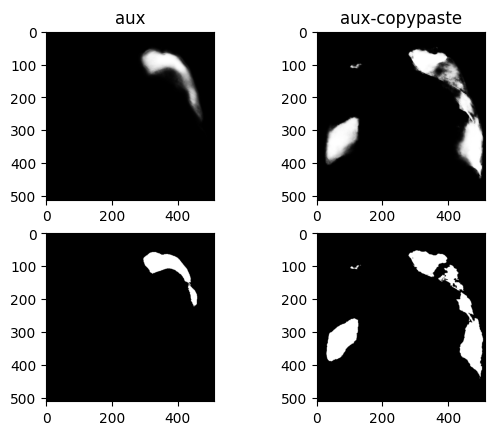

In [17]:
aux_mask1 = (aux_prob1 > 0.5) 
aux_mask2 = (aux_prob2 > 0.5) 

plt.subplot(2, 2, 1) 
plt.imshow(aux_prob1.squeeze().numpy(), cmap='gray') 
plt.title('aux')

plt.subplot(2, 2, 2) 
plt.imshow(aux_prob2.squeeze().numpy(), cmap='gray') 
plt.title('aux-copypaste') 

# plt.subplot(2, 3, 3) 
# plt.imshow(ensemble_prob.squeeze().numpy(), cmap='gray') 
# plt.title('ensemble')

plt.subplot(2, 2, 3)
plt.imshow(aux_mask1.squeeze().numpy(), cmap='gray')

plt.subplot(2, 2, 4)
plt.imshow(aux_mask2.squeeze().numpy(), cmap='gray') 

# plt.subplot(2, 3, 6)
# plt.imshow(ensemble_mask.squeeze().numpy(), cmap='gray')

plt.show() 

aux_logit1 tensor(5.1200) tensor(-45.2492) tensor(-11.7287) tensor(4.5178)
aux_logit2 tensor(11.0527) tensor(-31.7185) tensor(-10.4398) tensor(5.7374)
aux_prob1 tensor(0.9941) tensor(2.2312e-20) tensor(0.0297) tensor(0.1431)
aux_prob2 tensor(1.0000) tensor(1.6781e-14) tensor(0.0961) tensor(0.2689)


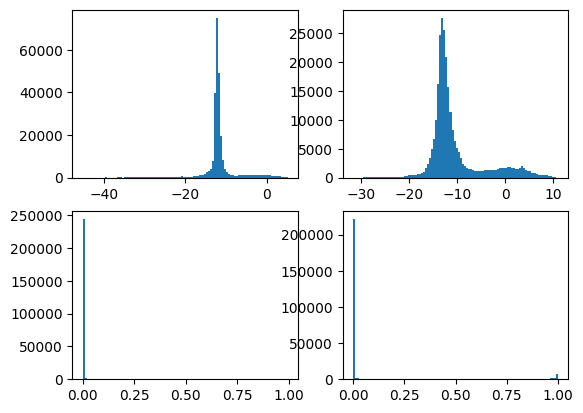

In [23]:
plt.subplot(2, 2, 1) 
plt.hist(aux_logit1.flatten(), bins=100)
print('aux_logit1', aux_logit1.max(), aux_logit1.min(), aux_logit1.mean(), aux_logit1.std())    

plt.subplot(2, 2, 2) 
plt.hist(aux_logit2.flatten(), bins=100)
print('aux_logit2', aux_logit2.max(), aux_logit2.min(), aux_logit2.mean(), aux_logit2.std()) 

plt.subplot(2, 2, 3)
plt.hist(aux_prob1.flatten(), bins=100)
print('aux_prob1', aux_prob1.max(), aux_prob1.min(), aux_prob1.mean(), aux_prob1.std()) 

plt.subplot(2, 2, 4)
plt.hist(aux_prob2.flatten(), bins=100)
print('aux_prob2', aux_prob2.max(), aux_prob2.min(), aux_prob2.mean(), aux_prob2.std()) 


plt.show() 

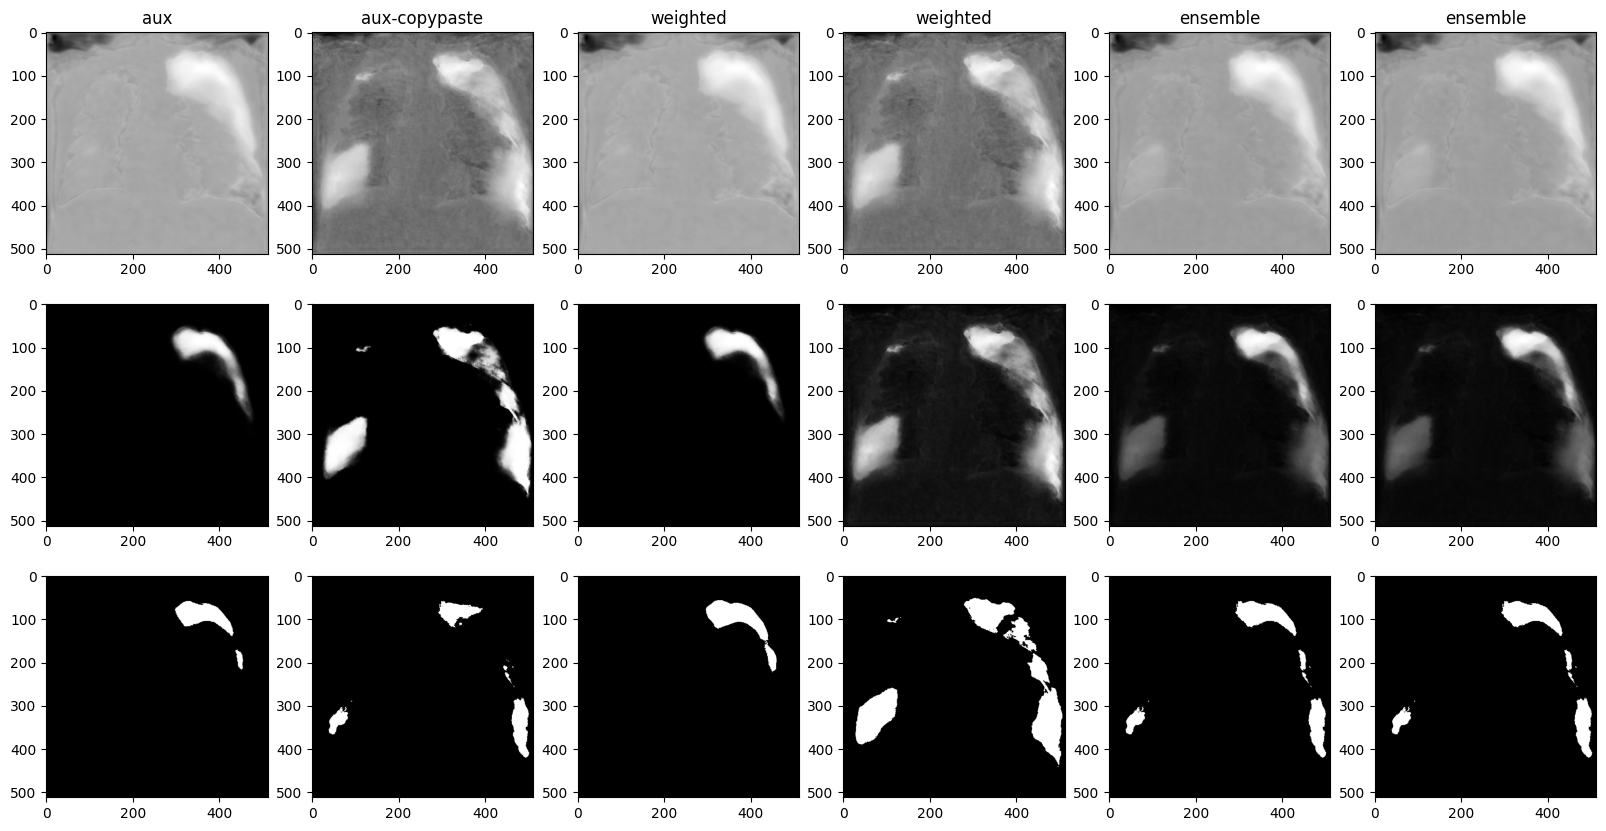

In [55]:
weighted_aux_logit1 = aux_logit1 * 1.2 
weighted_aux_logit2 = aux_logit2 * 0.2  

weighted_aux_prob1 = torch.sigmoid(weighted_aux_logit1) 
weighted_aux_prob2 = torch.sigmoid(weighted_aux_logit2) 

weighted_aux_mask1 = (weighted_aux_prob1 > 0.7) 
weighted_aux_mask2 = (weighted_aux_prob2 > 0.7) 

plt.figure(figsize=(20, 10))


plt.subplot(3, 6, 1) 
plt.imshow(aux_logit1.squeeze().numpy(), cmap='gray') 
plt.title('model1') 

plt.subplot(3, 6, 2) 
plt.imshow(aux_logit2.squeeze().numpy(), cmap='gray') 
plt.title('model2')

plt.subplot(3, 6, 3) 
plt.imshow(weighted_aux_logit1.squeeze().numpy(), cmap='gray')
plt.title('weighted') 

plt.subplot(3, 6, 4)
plt.imshow(weighted_aux_logit2.squeeze().numpy(), cmap='gray')
plt.title('weighted')

plt.subplot(3, 6, 5) 
plt.imshow(weighted_aux_logit1.squeeze().numpy() + weighted_aux_logit2.squeeze().numpy(), cmap='gray')
plt.title('ensemble') 

plt.subplot(3, 6, 6) 
plt.imshow(weighted_aux_logit1.squeeze().numpy() + weighted_aux_logit2.squeeze().numpy(), cmap='gray') 
plt.title('ensemble') 

plt.subplot(3, 6, 7) 
plt.imshow(aux_prob1.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 8) 
plt.imshow(aux_prob2.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 9) 
plt.imshow(weighted_aux_prob1.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 10)
plt.imshow(weighted_aux_prob2.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 11)
plt.imshow(weighted_aux_prob1.squeeze().numpy() + weighted_aux_prob2.squeeze().numpy(), cmap='gray')

plt.subplot(3, 6, 12)
plt.imshow(weighted_aux_prob1.squeeze().numpy() + weighted_aux_prob2.squeeze().numpy(), cmap='gray')

plt.subplot(3, 6, 13)
plt.imshow(weighted_aux_mask1.squeeze().numpy(), cmap='gray')

plt.subplot(3, 6, 14)
plt.imshow(weighted_aux_mask2.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 15) 
plt.imshow(aux_mask1.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 16)
plt.imshow(aux_mask2.squeeze().numpy(), cmap='gray')  

plt.subplot(3, 6, 17)
plt.imshow(weighted_aux_mask1.squeeze().numpy() + weighted_aux_mask2.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 18) 
plt.imshow(weighted_aux_mask1.squeeze().numpy() + weighted_aux_mask2.squeeze().numpy(), cmap='gray') 

plt.show() 

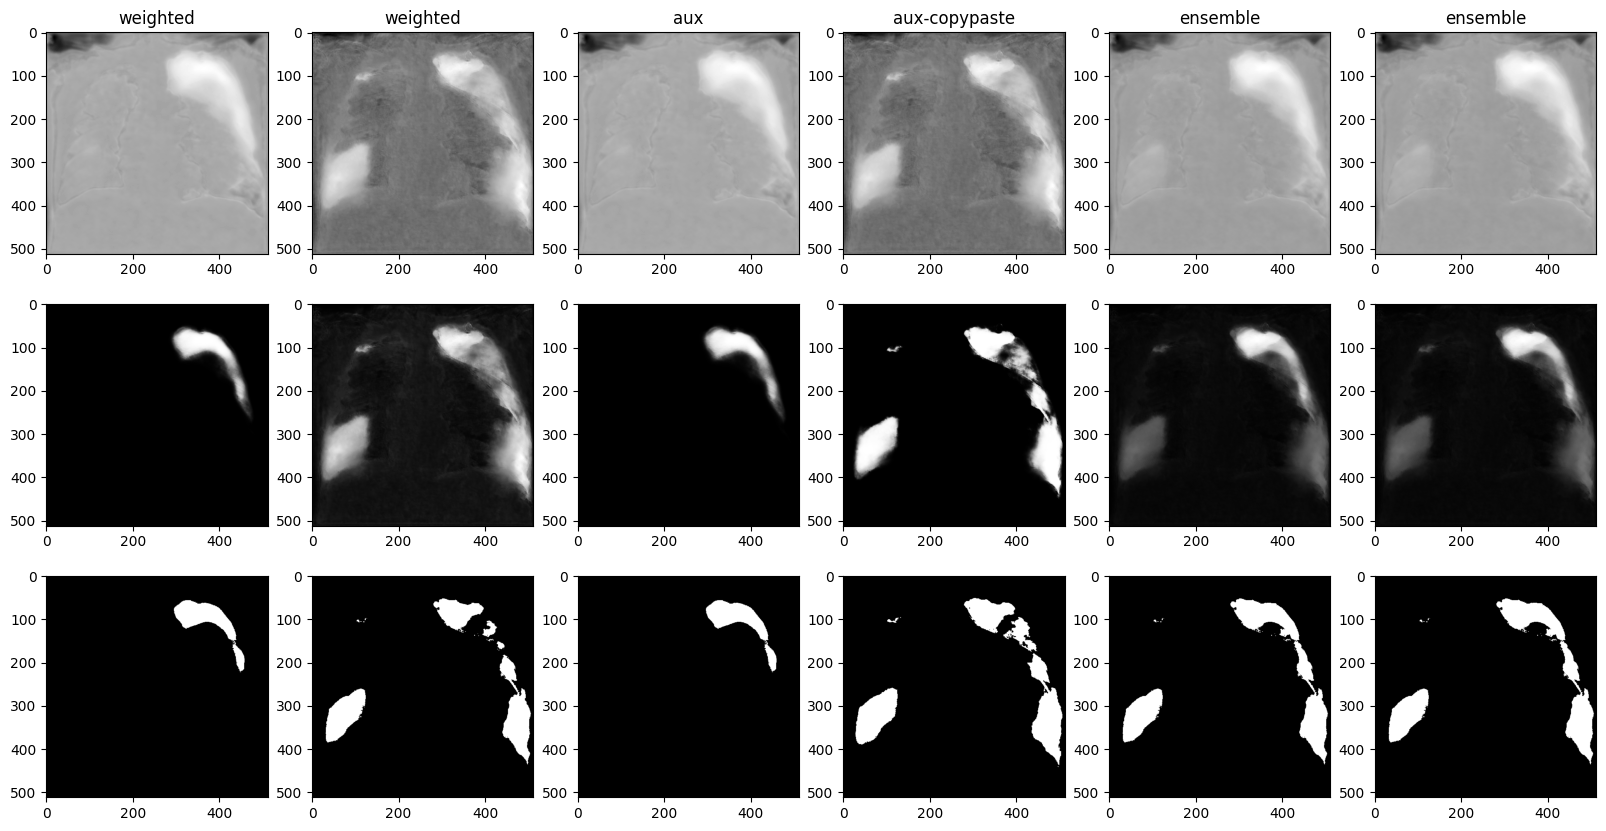

In [52]:
# 확률에 가중치 부여

weighted_aux_prob1 = torch.sigmoid(weighted_aux_logit1) * 1.0
weighted_aux_prob2 = torch.sigmoid(weighted_aux_logit2) * 0.9  

weighted_aux_mask1 = (weighted_aux_prob1 > 0.5) 
weighted_aux_mask2 = (weighted_aux_prob2 > 0.5) 

plt.figure(figsize=(20, 10))


plt.subplot(3, 6, 1) 
plt.imshow(aux_logit1.squeeze().numpy(), cmap='gray') 
plt.title('weighted')

plt.subplot(3, 6, 2) 
plt.imshow(aux_logit2.squeeze().numpy(), cmap='gray') 
plt.title('weighted') 

plt.subplot(3, 6, 3) 
plt.imshow(aux_logit1.squeeze().numpy(), cmap='gray')
plt.title('aux') 

plt.subplot(3, 6, 4)
plt.imshow(aux_logit2.squeeze().numpy(), cmap='gray')
plt.title('aux-copypaste')

plt.subplot(3, 6, 5) 
plt.imshow(weighted_aux_logit1.squeeze().numpy() + weighted_aux_logit2.squeeze().numpy(), cmap='gray')
plt.title('ensemble') 

plt.subplot(3, 6, 6) 
plt.imshow(weighted_aux_logit1.squeeze().numpy() + weighted_aux_logit2.squeeze().numpy(), cmap='gray') 
plt.title('ensemble') 

plt.subplot(3, 6, 7) 
plt.imshow(weighted_aux_prob1.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 8) 
plt.imshow(weighted_aux_prob2.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 9) 
plt.imshow(aux_prob1.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 10)
plt.imshow(aux_prob2.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 11)
plt.imshow(weighted_aux_prob1.squeeze().numpy() + weighted_aux_prob2.squeeze().numpy(), cmap='gray')

plt.subplot(3, 6, 12)
plt.imshow(weighted_aux_prob1.squeeze().numpy() + weighted_aux_prob2.squeeze().numpy(), cmap='gray')

plt.subplot(3, 6, 13)
plt.imshow(weighted_aux_mask1.squeeze().numpy(), cmap='gray')

plt.subplot(3, 6, 14)
plt.imshow(weighted_aux_mask2.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 15) 
plt.imshow(aux_mask1.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 16)
plt.imshow(aux_mask2.squeeze().numpy(), cmap='gray')  

plt.subplot(3, 6, 17)
plt.imshow(weighted_aux_mask1.squeeze().numpy() + weighted_aux_mask2.squeeze().numpy(), cmap='gray') 

plt.subplot(3, 6, 18) 
plt.imshow(weighted_aux_mask1.squeeze().numpy() + weighted_aux_mask2.squeeze().numpy(), cmap='gray') 

plt.show() 

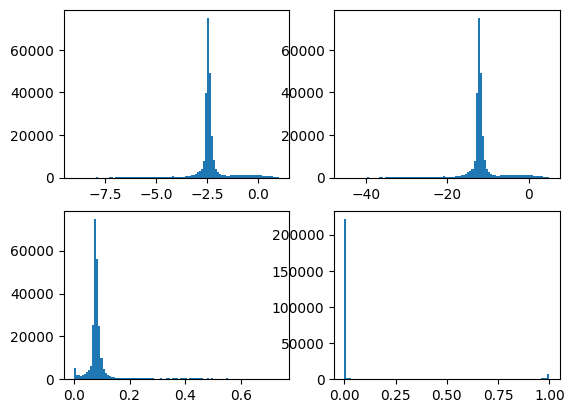

In [40]:
plt.subplot(2, 2, 1)
plt.hist(weighted_aux_logit1.flatten(), bins=100)  
plt.subplot(2, 2, 2) 
plt.hist(aux_logit1.flatten(), bins=100)
plt.subplot(2, 2, 3) 
plt.hist(weighted_aux_prob1.flatten(), bins=100) 
plt.subplot(2, 2, 4)
plt.hist(aux_prob2.flatten(), bins=100) 
plt.show() 

In [44]:
(weighted_aux_prob1 + aux_prob1).squeeze().numpy()

array([[0.1948691 , 0.11638869, 0.09053519, ..., 0.0970657 , 0.09905235,
        0.18988042],
       [0.11744499, 0.04451436, 0.02497832, ..., 0.02703312, 0.03264742,
        0.0882059 ],
       [0.08987266, 0.02625042, 0.01417431, ..., 0.02252307, 0.02972301,
        0.08802378],
       ...,
       [0.06886695, 0.03102977, 0.03854421, ..., 0.05098196, 0.04510527,
        0.10693834],
       [0.08177776, 0.03948734, 0.03482165, ..., 0.05188828, 0.05944839,
        0.13929044],
       [0.14996906, 0.07865454, 0.06414024, ..., 0.08270948, 0.10460039,
        0.21154356]], dtype=float32)

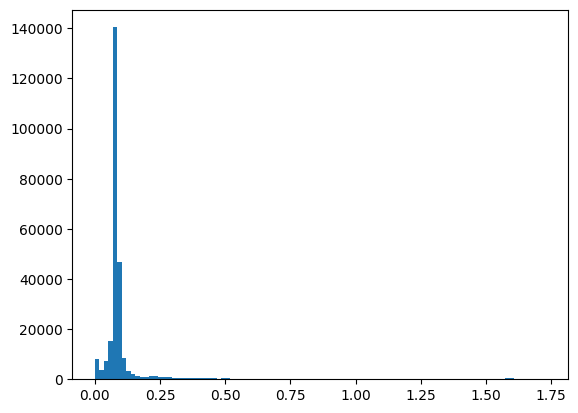

In [46]:
plt.hist(weighted_aux_prob1.flatten() + aux_prob1.flatten(), bins=100) 
plt.show() 

In [56]:
aux_cls1 - aux_cls2

tensor([[-11.7980]])

In [62]:
(abs(torch.sigmoid(aux_cls1) - 0.5) - abs(torch.sigmoid(aux_cls2) - 0.5)) / 2

tensor([[0.0689]])

In [64]:
print(abs(torch.sigmoid(aux_cls1) - 0.5) - 0.0689)   # 음성 
print(abs(torch.sigmoid(aux_cls2) - 0.5) - 0.0689)  # 양성 

tensor([[0.4311]])
tensor([[0.2932]])


In [65]:
a = np.array([1, 2, 3, 4, 5])  

np.mean(a - a.mean()) 

0.0

In [71]:
# EBC -> BC (2, 4, 4) -> (4, 4)
probabilities = torch.tensor(
                        [[[1, 1, 1, 1],  
                          [1, 1, 1, 1],
                          [1, 1, 1, 1], 
                          [1, 1, 1, 1]], 
                         [[2, 2, 2, 2],
                          [2, 2, 2, 2],
                          [2, 2, 2, 2], 
                          [2, 2, 2, 2]]], dtype=torch.float32)  

prob_mean = probabilities.mean(dim=0) 
print(prob_mean.shape) 
prob_mean  

torch.Size([4, 4])


tensor([[1.5000, 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000]])

In [132]:
m = probabilities - prob_mean
print(m.shape) 
print(m)

torch.Size([2, 4, 4])
tensor([[[-0.5000, -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000, -0.5000]],

        [[ 0.5000,  0.5000,  0.5000,  0.5000],
         [ 0.5000,  0.5000,  0.5000,  0.5000],
         [ 0.5000,  0.5000,  0.5000,  0.5000],
         [ 0.5000,  0.5000,  0.5000,  0.5000]]])


In [134]:
np.where(m > 0, m * 2, m * 3) 

array([[[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[ 1. ,  1. ,  1. ,  1. ],
        [ 1. ,  1. ,  1. ,  1. ],
        [ 1. ,  1. ,  1. ,  1. ],
        [ 1. ,  1. ,  1. ,  1. ]]], dtype=float32)

In [89]:
print(probabilities.shape) 

# 1, 1, 2  EBC 
weight = torch.tensor([[[2.0, 1.0]]])

# EBCWH  # 1, 1, 2, 4, 4
masks = torch.tensor([[
                       [[[1, 1, 1, 1],  
                       [1, 1, 1, 1],
                       [1, 1, 1, 1], 
                       [1, 1, 1, 1]], 
                      [[2, 2, 2, 2],
                       [2, 2, 2, 2],
                       [2, 2, 2, 2], 
                       [2, 2, 2, 2]]]
                    ]], dtype=torch.float32) 

masks * weight.unsqueeze(-1).unsqueeze(-1)  

torch.Size([2, 4, 4])


tensor([[[[[2., 2., 2., 2.],
           [2., 2., 2., 2.],
           [2., 2., 2., 2.],
           [2., 2., 2., 2.]],

          [[2., 2., 2., 2.],
           [2., 2., 2., 2.],
           [2., 2., 2., 2.],
           [2., 2., 2., 2.]]]]])

In [102]:
def get_weight(prob, alpha=2): # prob_cls: EBC 
    conf = abs(prob - 0.5)  # EBC 
    print('conf', conf)
    m = conf - conf.mean(dim=0)  # EBC, mean = 0 
    print('m', m) 
    weight = alpha * torch.sqrt(m - 1) + 1  # EBC 

    return weight  

prob = torch.tensor([
    [[0.9]], [[0.7]]
])
get_weight(prob) 

conf tensor([[[0.4000]],

        [[0.2000]]])
m tensor([[[ 0.1000]],

        [[-0.1000]]])


tensor([[[nan]],

        [[nan]]])

In [136]:
m = torch.tensor(-0.25 + 1)   
1 * torch.sqrt(m - 1) + 1  if m > 1.0 else -1 * torch.sqrt(1 - m) + 1  # alpha < 2  

np.where(m > 1.0, 1 * torch.sqrt(m - 1) + 1, -1 * torch.sqrt(1 - m) + 1) 

array(0.5, dtype=float32)

In [108]:
torch.sqrt(torch.tensor(0.8))  

tensor(0.8944)

In [79]:


abs(torch.tensor([[-1, 1, 0, 3, -4]])) 

tensor([[1, 1, 0, 3, 4]])

True

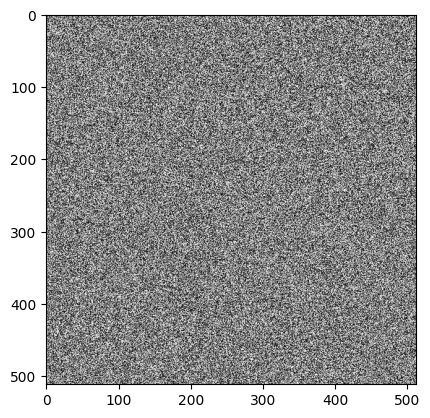

In [92]:
temp_mask = torch.rand(512, 512) 

plt.imshow(temp_mask, cmap='gray')

cv2.imwrite('temp_mask.png', temp_mask.numpy()*0.0001 * 255) 

In [95]:
prob_mask = np.load('/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/ensemble_result/exp7_exp10_exp9_exp6_12-07-17-32/BORA_CXR_000073.json_prob_mask.npy') 
prob_mask.shape 

(512, 512)

In [96]:
prob_mask 

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [99]:
temp = np.random.randn(512, 512) 
np.save('temp.npy', temp) 

In [139]:
temp = np.load('/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/ensemble_result/exp7_exp10_exp9_exp6_12-07-18-53/BORA_CXR_000474.json_prob_mask.npy') 
temp 

array([[1.0968416e-02, 2.3720434e-03, 1.6987683e-03, ..., 8.4005221e-04,
        1.8648681e-03, 5.7852780e-03],
       [2.1419893e-03, 6.2621926e-04, 6.2899961e-04, ..., 1.7143082e-04,
        3.1309164e-04, 1.1770471e-03],
       [2.7935465e-03, 9.4223558e-04, 9.5572887e-04, ..., 3.2229823e-04,
        3.7446365e-04, 1.2194217e-03],
       ...,
       [1.7268606e-03, 3.2083705e-04, 1.1141950e-04, ..., 6.6371693e-05,
        9.6709286e-05, 1.4996260e-03],
       [6.2443409e-03, 5.9991173e-04, 1.7502930e-04, ..., 1.6232430e-04,
        2.0421733e-04, 3.1952884e-03],
       [3.0050686e-02, 3.5642914e-03, 1.9364506e-03, ..., 4.7118342e-03,
        5.7695811e-03, 3.3011839e-02]], dtype=float32)

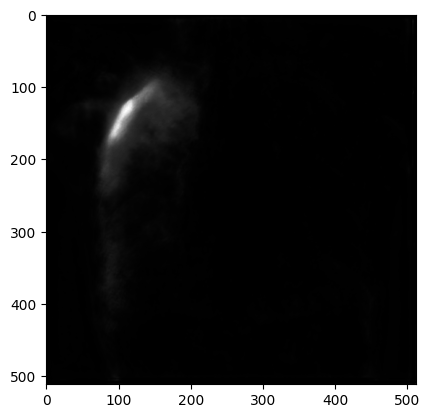

In [140]:
plt.imshow(temp, cmap='gray') 

In [141]:
temp.max() 

0.31176287

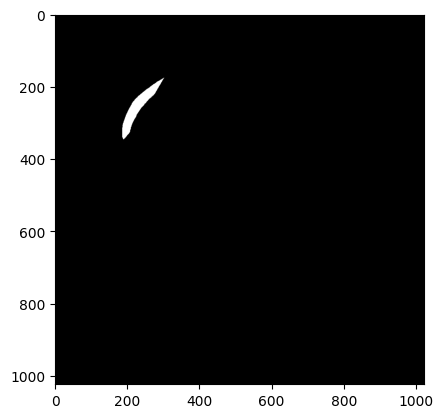

: 

In [144]:
label = json.load(open('/ai-data/chest/kjs2109/pseudo_label_dataset/chestALL/annotations/1findings/v0/BORA_CXR_000474.json', 'r')) 
anns = label['annotations'] 

gt_mask = np.zeros((1024, 1024), np.int32)
for ann in anns: 
    polygon = ann['segmentation'][0] 
    polygon_x = [x for i, x in enumerate(polygon) if i % 2 == 0] 
    polygon_y = [y for i, y in enumerate(polygon) if i % 2 == 1] 
    polygon_xy = np.array([[x, y] for x, y in zip(polygon_x, polygon_y)], np.int32) 
    cv2.fillPoly(gt_mask, [polygon_xy], 1) 

plt.imshow(gt_mask, cmap='gray') 